In [1]:
import pandas as pd
pd.set_option("display.max_columns", 100)
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from haversine import haversine
CSV_DATA = Path().cwd().parent.parent / "data/0_extracted/processed/"

In [2]:
def read_ride_csv(file_path:str, time_columns:list[str]=None):
    if time_columns is None: time_columns=['time']
    # Read in the CSV file for the Ride
    df = pd.read_csv(file_path)
    
    # guarantee the timestamps are datetime objects
    for time_col in time_columns:
        df[time_col] = pd.to_datetime(df[time_col])

    return df

In [3]:
jan_ride_path = CSV_DATA / "January_no_sensor.csv"
apr_ride_path = CSV_DATA / "April_one_sensor.csv"
may_ride_path = CSV_DATA / "May_two_sensor.csv"
df_jan = read_ride_csv(jan_ride_path)
df_apr = read_ride_csv(apr_ride_path)
df_may = read_ride_csv(may_ride_path)

In [4]:
drop_columns = ['ride_id', 'track_id']
df_jan = df_jan.drop(columns=drop_columns)
df_apr = df_apr.drop(columns=drop_columns)
df_may = df_may.drop(columns=drop_columns)
add_null_columns = ['atemp', 'hr'] # if these columns don't already exist add them as np.null

for df in [df_jan, df_apr, df_may]:
    for col in add_null_columns:
        if col not in df.columns:
            df[col] = np.nan

In [5]:
df_apr.head(5)

,segment_id,time,elevation,latitude,longitude,atemp,hr
0,-1,2025-04-12 17:21:13+00:00,147.4,39.139397,-84.341631,29,93
1,-1,2025-04-12 17:21:14+00:00,147.4,39.139397,-84.341631,29,91
2,-1,2025-04-12 17:21:15+00:00,147.4,39.139397,-84.341631,29,94
3,-1,2025-04-12 17:21:16+00:00,147.4,39.139397,-84.341631,29,90
4,-1,2025-04-12 17:21:20+00:00,147.4,39.139397,-84.341631,29,87


In [6]:
df_apr.describe()

,segment_id,elevation,latitude,longitude,atemp,hr
count,2103.0,2103.000000,2103.000000,2103.000000,2103.000000,2103.000000
mean,-1.0,178.418450,39.211820,-84.294173,23.011412,142.721826
std,0.0,10.000147,0.042237,0.022513,2.121626,21.757117
min,-1.0,147.200000,39.139293,-84.341768,19.000000,80.000000
25%,-1.0,175.400000,39.175062,-84.308777,21.000000,132.000000
50%,-1.0,182.800000,39.213800,-84.293249,23.000000,150.000000
75%,-1.0,184.600000,39.251340,-84.282507,24.000000,159.000000
max,-1.0,191.600000,39.268558,-84.258291,29.000000,174.000000


# 1. Analyzing Time Synchronicity
Goal: Understand if rows sampled at a consistent rate?

In [7]:
def enrich_time_data(df:pd.DataFrame, time_column:str='time', fill_first:float=1.0):
    df = df.copy()
    # Temporarily get the number of seconds since Jan. 1, 1970 as the UTC timestamp
    df['time_utc'] = df[time_column].apply(lambda x: x.timestamp())
    
    # Calculate the row-wise difference in time (in seconds)
    df['delta_time'] = df['time_utc'].diff()
    
    # drop the temporary time column
    df.drop(['time_utc'], axis=1, inplace=True)
    
    # fill in the initial value of delta_time with @fill_first
    df['delta_time'] = df['delta_time'].fillna(fill_first)
    
    return df



In [8]:
df_jan = enrich_time_data(df_jan)
df_apr = enrich_time_data(df_apr)
df_may = enrich_time_data(df_may)

# create an elapsed time column
df_jan['elapsed_time'] = df_jan['delta_time'].cumsum()
df_apr['elapsed_time'] = df_apr['delta_time'].cumsum()
df_may['elapsed_time'] = df_may['delta_time'].cumsum()

In [9]:
df_jan['delta_time'].value_counts()

delta_time
1.0      3798
2.0        12
281.0       1
12.0        1
73.0        1
74.0        1
14.0        1
86.0        1
Name: count, dtype: int64

In [10]:
df_apr['delta_time'].value_counts()

delta_time
1.0     373
2.0     368
3.0     289
4.0     278
5.0     207
6.0     176
7.0     169
8.0     113
9.0      65
10.0     23
11.0     12
12.0     10
13.0      5
16.0      3
14.0      2
19.0      2
15.0      2
17.0      2
26.0      1
21.0      1
22.0      1
18.0      1
Name: count, dtype: int64

In [11]:
df_may['delta_time'].value_counts()

delta_time
1.0     132
2.0      91
3.0      29
5.0      14
4.0      14
6.0       6
7.0       3
21.0      2
8.0       2
9.0       1
13.0      1
10.0      1
12.0      1
Name: count, dtype: int64

**Observation:** typically the ride is sampled once per second, but Strava also has a feature to auto-pause activities. So these gaps in successive timestamps can occur due to stopping on the ride or simple issues with the sampling.

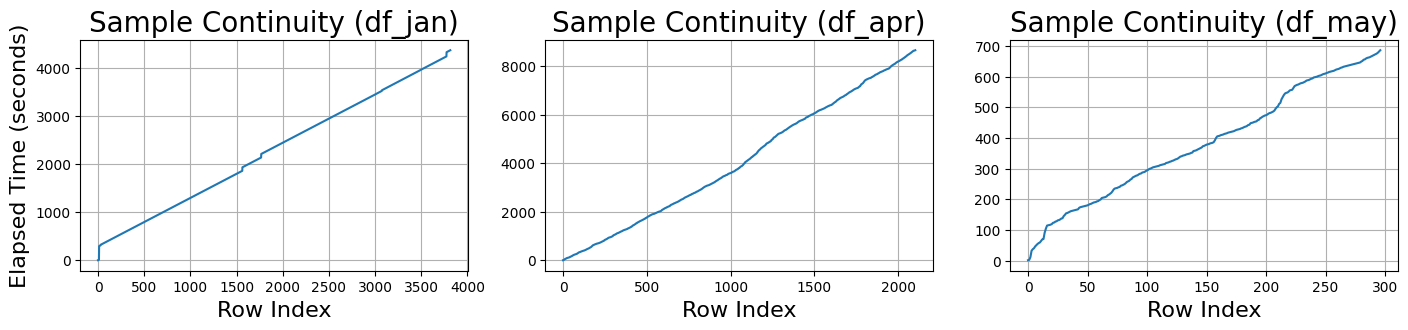

In [12]:
# visualize the jumps of cumulative time 
fig, axes = plt.subplots(1,3,figsize=(17,3))

_ = axes[0].plot(df_jan['elapsed_time'])
_ = axes[0].set_xlabel('Row Index', fontsize=16)
_ = axes[0].set_ylabel('Elapsed Time (seconds)', fontsize=16)
_ = axes[0].set_title('Sample Continuity (df_jan)', fontsize=20)
_ = axes[0].grid()

_ = axes[1].plot(df_apr['elapsed_time'])
_ = axes[1].set_xlabel('Row Index', fontsize=16)
_ = axes[1].set_title('Sample Continuity (df_apr)', fontsize=20)
_ = axes[1].grid()


_ = axes[2].plot(df_may['elapsed_time'])
_ = axes[2].set_xlabel('Row Index', fontsize=16)
_ = axes[2].set_title('Sample Continuity (df_may)', fontsize=20)
_ = axes[2].grid()

**Observation**: We can observe the large `delta_time` values as abrupt vertical jumps in the cumulative time vs. row index plots above. The January ride appears to have the most visible jumps.

Curiously, although the January ride has roughly have the elapsed time as the April ride, it has nearly double the number of rows...

### When Time Discontinuities occur, do other Ride Columns show similar jumps?

In [13]:
def get_time_gap_indices(df: pd.DataFrame, time_gap_threshold:int=15) -> list:
    # Calculate when the time discontinuities occur
    filt_time_jump = df['delta_time'] >= time_gap_threshold
    time_gap_indices = list(df.loc[filt_time_jump, 'time'].index)
    return time_gap_indices

def plot_state_by_index(df: pd.DataFrame, state_column:str, discontinuities:list=None, 
                        figsize:tuple[float]=(8,3), row_bounds:list[int]=None, y_lim_scale:float=0.005):
    fig = plt.figure(figsize=figsize)
    # Mark the discontinuities
    if discontinuities is None:
        discontinuities = get_time_gap_indices(df)
        
    for discont_index in discontinuities:
        _ = plt.axvline(discont_index, color='r')
    
    # Plot the state
    _ = plt.plot(df.loc[:, state_column], linestyle='-', marker='.', markersize=10)
    _ = plt.xlabel('Row Index', fontsize=16)
    _ = plt.ylabel(f'{state_column}', fontsize=16)
    _ = plt.title(f'Sample Continuity of {state_column}', fontsize=20)
    _ = plt.grid()
    
    # Manage the axes limits
    if row_bounds is not None:
        _ = plt.xlim(row_bounds)
    else:
        row_bounds = range(df.shape[0])
        
    y_min = np.min(df.loc[row_bounds, state_column])
    y_max = np.max(df.loc[row_bounds, state_column])
    
    #_ = plt.ylim([(1-y_lim_scale)*y_min, (1+y_lim_scale)*y_max])
    

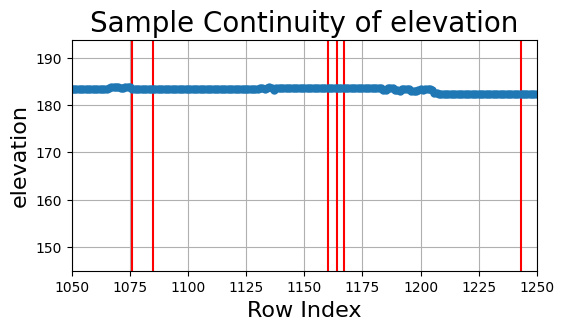

In [14]:
plot_state_by_index(df_apr, 'elevation', row_bounds=[1050,1250], figsize=(6,3))

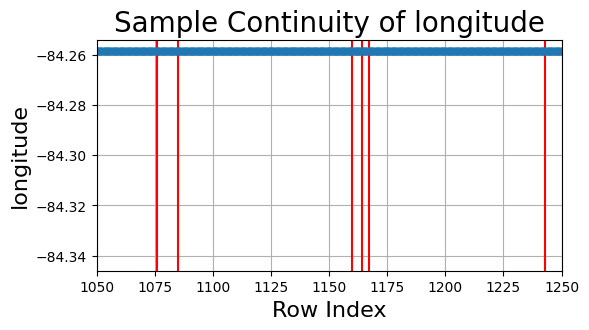

In [15]:
plot_state_by_index(df_apr, 'longitude', row_bounds=[1050,1250], figsize=(6,3))

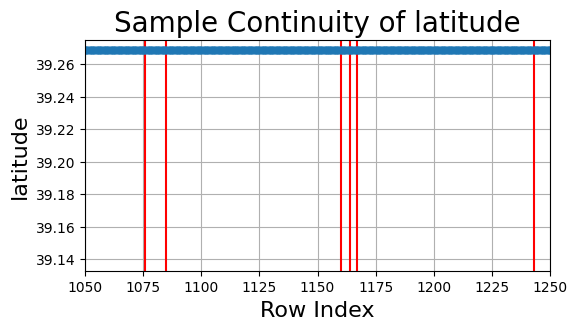

In [16]:
plot_state_by_index(df_apr, 'latitude', row_bounds=[1050,1250], figsize=(6,3))

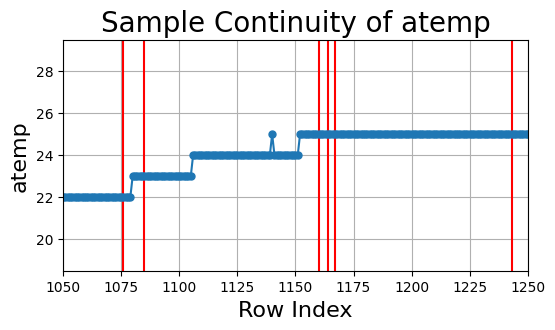

In [17]:
plot_state_by_index(df_apr, 'atemp', row_bounds=[1050,1250], figsize=(6,3))

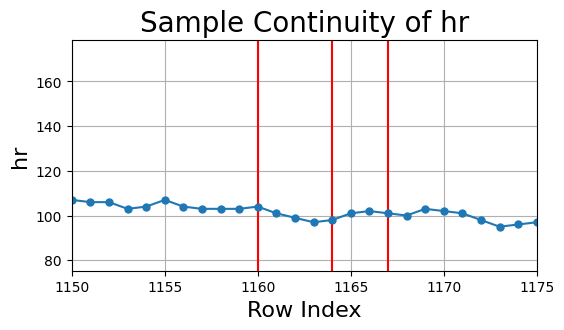

In [18]:
plot_state_by_index(df_apr, 'hr', row_bounds=[1150,1175], figsize=(6,3))

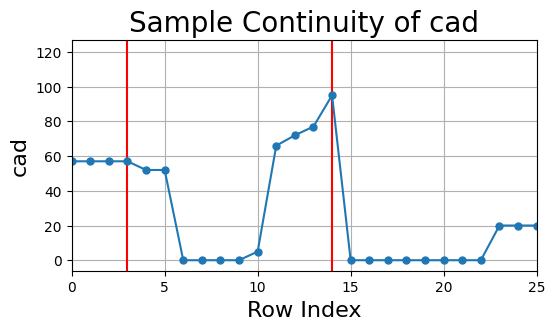

In [19]:
plot_state_by_index(df_may, 'cad', row_bounds=[0,25], figsize=(6,3))

**Observation**: Sensor values like ambient temperature and more quickly-changing values like heart rate `hr` and cadence `cad` also seem to be continuous, despite time sampling skips.

# Normalizing Time Within Continuous Segments
So far I have left the `segment_id` column alone as -1, but not we can fill it in here to indicated the row groups of continuous activity

In [ ]:
def label_continuous_segments(df: pd.DataFrame, time_gap_threshold:int=15):
    df = df.copy()
    # get the time gap indices
    time_gap_indices = get_time_gap_indices(df, time_gap_threshold=time_gap_threshold)

    # intialize the initial segment_id. to be incremented for each region of continuous data
    segment_id_counter = 0
    # initialize the starting index of the first segment
    segment_start_index = 0

    for time_gap_index in time_gap_indices:
        # Assign the Segment ID
        df.loc[segment_start_index:time_gap_index-1, 'segment_id'] = segment_id_counter
        
        # update the segment_id counter and start index
        segment_id_counter += 1
        segment_start_index = time_gap_index
        
    # Since segment_id == -1 by default, this represents the final segment of activity once parsed
    df['segment_id'] = df['segment_id'].replace({-1:segment_id_counter})

    # Since the delta_time column is no longer needed to detect discontinuities,
    # Drop delta_time so we can rebuild it at a segment_id level
    df.drop(['delta_time'], axis=1, inplace=True)
    return df



In [21]:
df_jan = label_continuous_segments(df_jan)
df_apr = label_continuous_segments(df_apr)
df_may = label_continuous_segments(df_may)

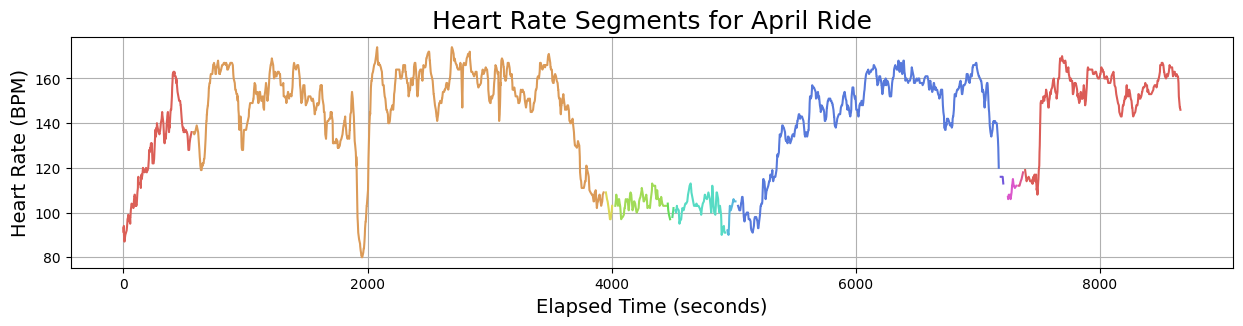

In [31]:
_ = plt.figure(figsize=(15,3))
_ = sn.lineplot(df_apr, x='elapsed_time', y='hr', hue='segment_id', palette='hls', legend=False)
_ = plt.grid()
_ = plt.title('Heart Rate Segments for April Ride', fontsize=18)
_ = plt.xlabel('Elapsed Time (seconds)', fontsize=14)
_ = plt.ylabel('Heart Rate (BPM)', fontsize=14)

### Define the Upsampling Process through a "split-apply-combine" technique

In [33]:
def upsample_and_interpolate(df: pd.DataFrame, time_column:str='time', method:str='linear', limit_direction:str='forward'):
    # set the timestamp as the index for the dataframe
    df = df.set_index(time_column).copy()
    df = df.resample('s').interpolate(method=method, limit_direction=limit_direction).reset_index()
    return df

def normalize_sampling_rate(df: pd.DataFrame, partition_column:str='segment_id') -> pd.DataFrame:
    df = df.copy()
    functions_to_apply = [upsample_and_interpolate, enrich_time_data]
    for func in functions_to_apply:
        df = pd.concat(list(map(func, [df_group for _,df_group in df.groupby(partition_column)])), ignore_index=True).sort_index()
    return df

In [36]:
df_jan_up = normalize_sampling_rate(df_jan)
df_apr_up = normalize_sampling_rate(df_apr)
df_may_up = normalize_sampling_rate(df_may)

# For each original dataframe, show its number of rows and columns
print('Original Dataframe sizes (Jan, Apr, May):')
print(df_jan.shape, df_apr.shape, df_may.shape)
print('Upsampled/Interpolated Dataframe sizes (Jan, Apr, May):')
print(df_jan_up.shape, df_apr_up.shape, df_may_up.shape)

Original Dataframe sizes (Jan, Apr, May):
(3816, 8) (2103, 8) (297, 9)
Upsampled/Interpolated Dataframe sizes (Jan, Apr, May):
(3852, 9) (8439, 9) (646, 10)


**Question:** Why did the April interpolation multiply the row count by ~4? and May by ~2?

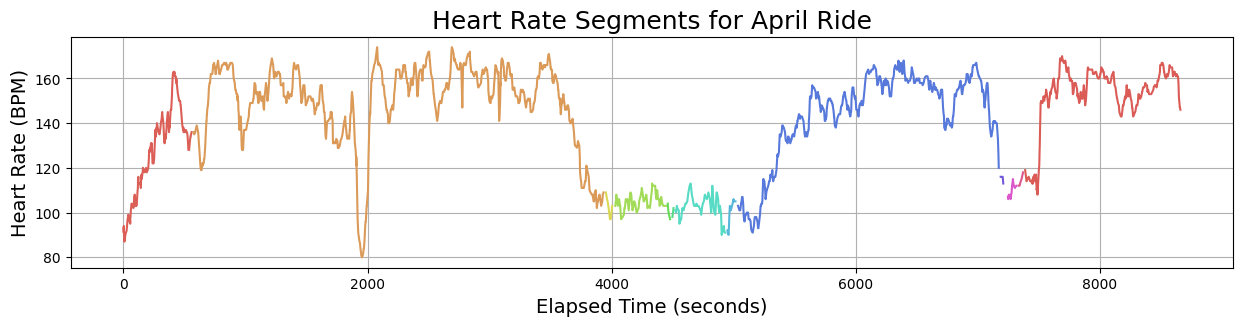

In [37]:
_ = plt.figure(figsize=(15,3))
_ = sn.lineplot(df_apr_up, x='elapsed_time', y='hr', hue='segment_id', palette='hls', legend=False)
_ = plt.grid()
_ = plt.title('Heart Rate Segments for April Ride', fontsize=18)
_ = plt.xlabel('Elapsed Time (seconds)', fontsize=14)
_ = plt.ylabel('Heart Rate (BPM)', fontsize=14)

In [38]:
df_apr_up.delta_time.describe()

count    8439.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
Name: delta_time, dtype: float64

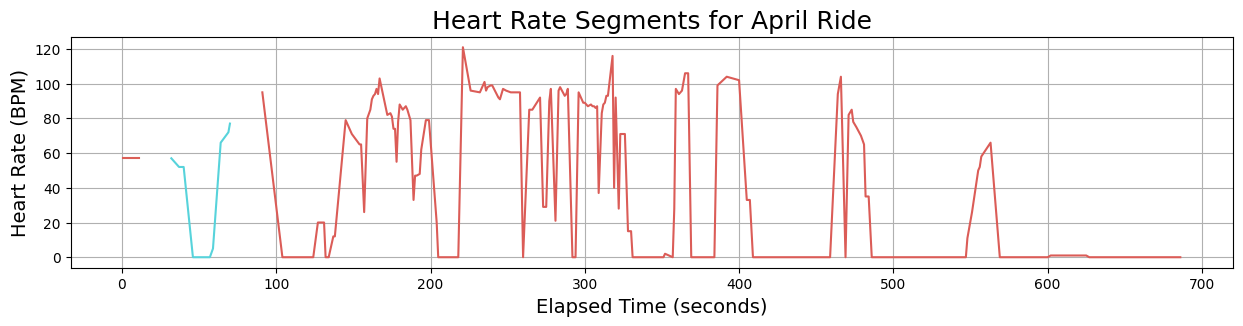

In [41]:
_ = plt.figure(figsize=(15,3))
_ = sn.lineplot(df_may_up, x='elapsed_time', y='cad', hue='segment_id', palette='hls', legend=False)
_ = plt.grid()
_ = plt.title('Heart Rate Segments for April Ride', fontsize=18)
_ = plt.xlabel('Elapsed Time (seconds)', fontsize=14)
_ = plt.ylabel('Heart Rate (BPM)', fontsize=14)